## Quantum subset-sum

Here we solve a specific instance of the quantum subset sum problem, described below. This was my submission for the QOSF Mentorship Cohort 5. The decision version of this (deciding whether there is a subset that adds to a certain value) [is known to be NP-Hard](https://en.wikipedia.org/wiki/Subset_sum_problem?oldformat=true) in many cases.

### The problem

Design a quantum circuit that finds the subsets of $[5,7,8,9,1]$ for which the elements add to $16$.

### Basic idea

**Note:** I spend some time here going over my thought process as I approached this problem, and the first thing I thought of was not good. **To jump straight to the solution that worked, go [here](#another_cell)**.

I can use one-hot encoding for the subsets, for example, the subset with the first and third elements can be represented as the vector $\ket{10100}$. I can generate a uniform superposition over all such vectors by a Hadamard transform on the state $\ket{00000}$. If I have an oracle that can compute the sum of a subset with such an encoding of the subset as input, an oracle call can write the sum of elements of the subset to a quantum register. I can then query this oracle with the uniform superposition over all such encodings and measure the 'answer' register. If the answer register reads $16$, then the qubits encoding the subset will have a possible subset that adds to $16$.

We start by importing the required libraries and tools.

In [498]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import circuit_drawer

We set two global variables. $N$ is the size of the input list and $B$ is the number of qubits required to encode each element of the list. In this case, even though the largest number in the list is $9$ which can be encoded using $4$ qubits, since I eventually want to compute the subset sums, I choose to represent the elements using $B = 5$ qubits. The extra qubit will contain any carry-overs.

In [499]:
LIST = [5,7,8,9,1]
N = len(LIST)
B = 5

### First Pass at the Oracle

The oracle would contain $N$ query qubits and $N \times B + B$ ancilla qubits. The first $B \times N$ ancilla qubits would be memory qubits, each set of $B$ qubits initialized, using $X$ gates, to represent an encoding of the numbers in the list. The sum of the elements of the queried subset would be stored in the last $B$ ancilla qubits. The sum is computed using controlled Draper QFT Adders, where the uncontrolled version was from the Qiskit Circuit Library. Specifically, the adders are always between one of the $N$ sets of memory qubits and the sum qubits. There are $N$ adders, each controlled using one wire of the query qubits. If a control qubit is one, the circuit adds the corresponding number to the sum qubits. For now, I have kept $N+B$ classical bits to store the result of measuring the query qubits and the sum qubits. 

In [500]:
from qiskit.circuit.library import DraperQFTAdder
controlled_adder = DraperQFTAdder(B).control(1)

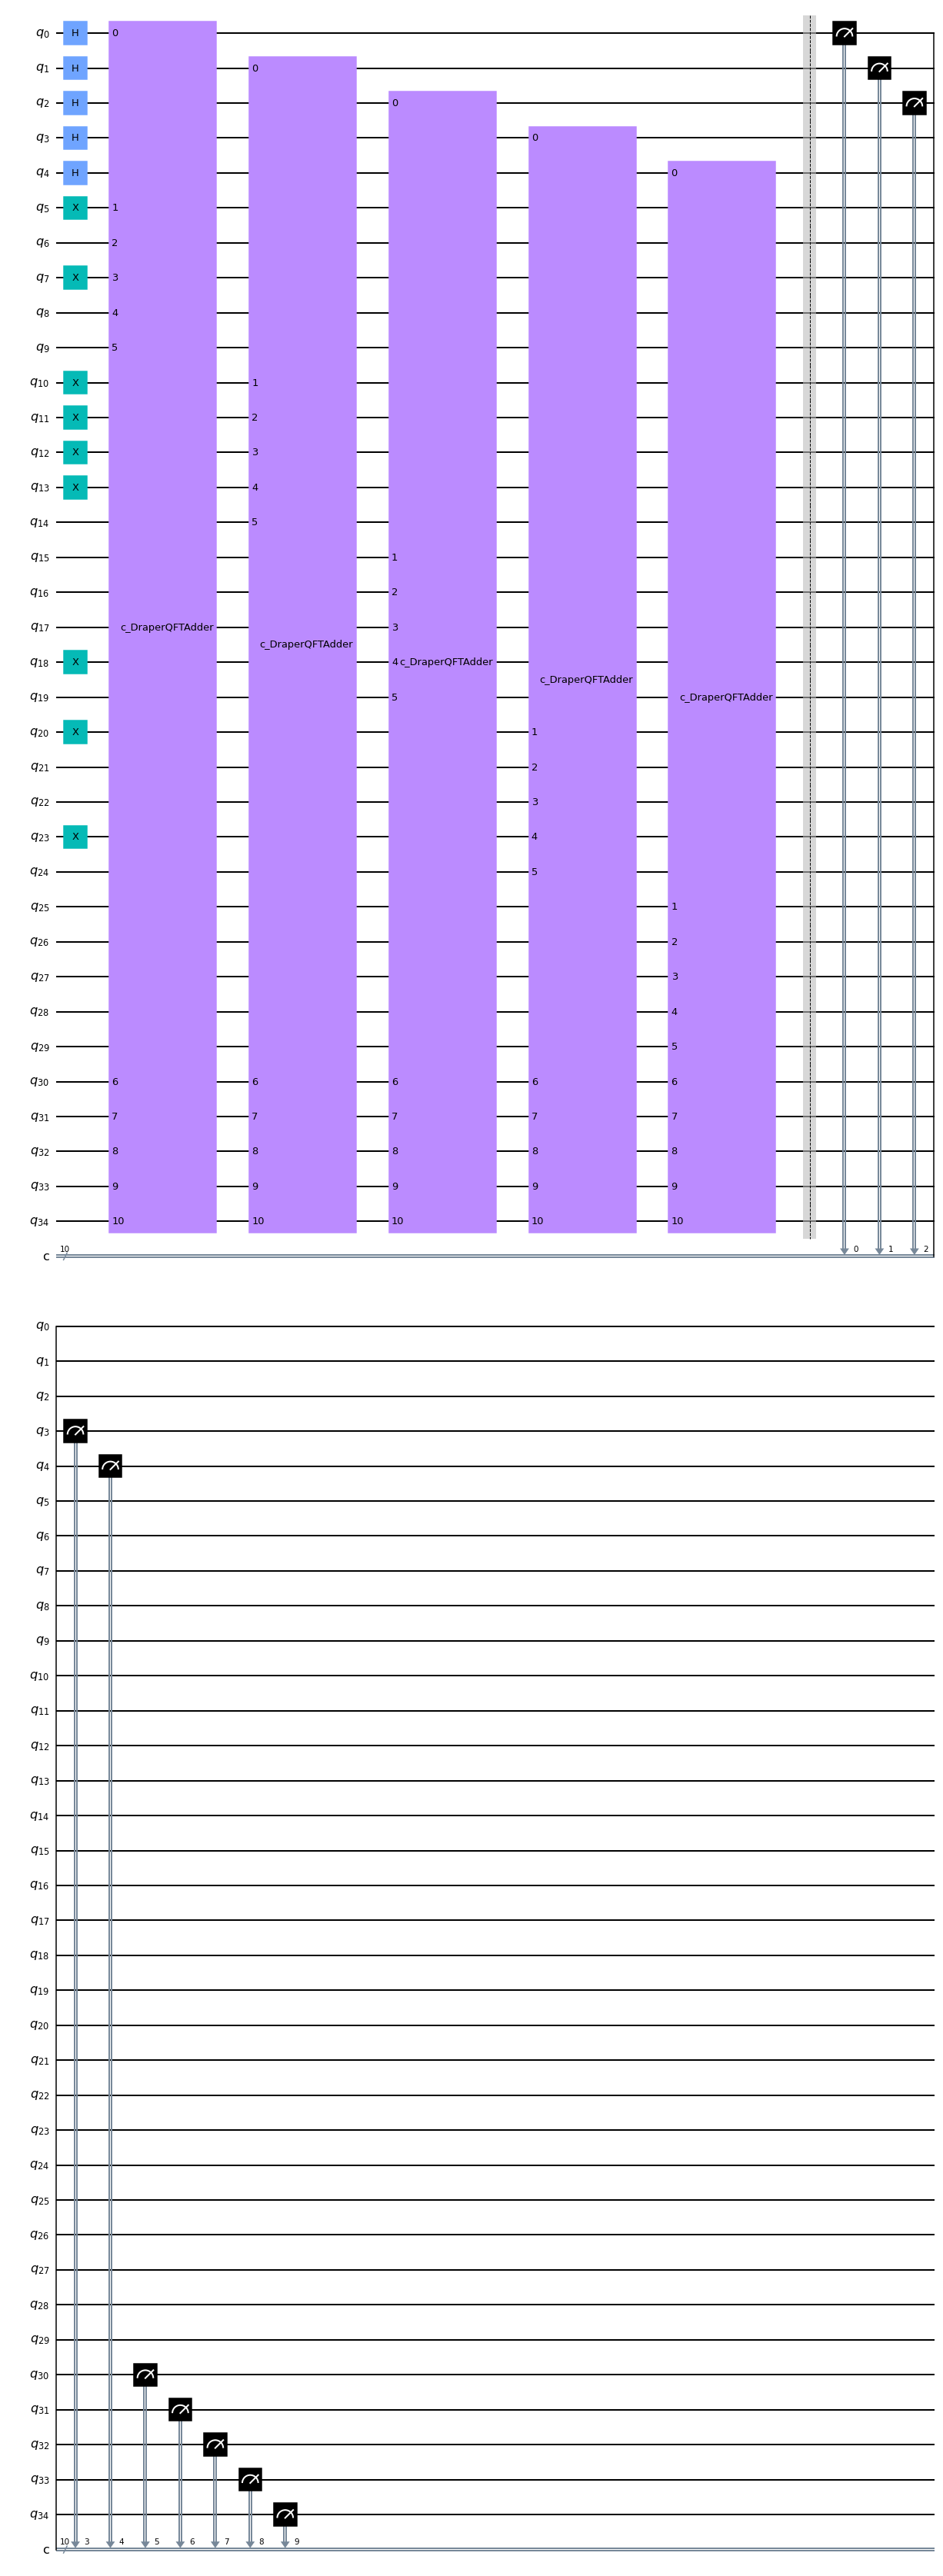

In [501]:
qc = QuantumCircuit(N + N*B + B, N+B)
for i in range(N):
    qc.h([i])
qc.x([5])
qc.x([7])
qc.x([10])
qc.x([11])
qc.x([12])
qc.x([13])
qc.x([18])
qc.x([20])
qc.x([23])

qc.append(controlled_adder, [0,5,6,7,8,9,30,31,32,33,34])
qc.append(controlled_adder, [1,10,11,12,13,14,30,31,32,33,34])
qc.append(controlled_adder, [2,15,16,17,18,19,30,31,32,33,34])
qc.append(controlled_adder, [3,20,21,22,23,24,30,31,32,33,34])
qc.append(controlled_adder, [4,25,26,27,28,29,30,31,32,33,34])

qc.barrier()
qc.measure([0,1,2,3,4,30,31,32,33,34],range(N+B))

circuit_drawer(qc, output='mpl')

... which seems to work fine, until I get to the next step: compiling and running the circuit.

In [502]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=1)

# Grab the results from the job.
result_sim = job_sim.result()

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-299496 using the statevector simulator.


😫

Of course, that's hardly surprising. I just attempted to create a circuit with $35$ qubits. That's $34359738368$ possible states. Even if the coefficient of each state could be represented by just a single bit, that's over 4GB of memory! Clearly this is not the right way to create an oracle.

### Oracle, version 2

<a id='another_cell'></a>

This time, the oracle will contain just $N$ query qubits and $B + B$ ancilla qubits. Using the query qubits as control, I can write the elements of the list to the first $B$ ancilla qubits. Then I can use a Draper adder between the first and second sets of $B$ ancilla qubits - this will add the number in the first $B$ ancilla qubits to the second $B$ ancilla qubits. I then restore the first $B$ qubits to the $\ket{00000}$ state by applying the same controlled gates again, and proceed. Eventually, I get the subset sum in the last $B$ ancilla qubits. The oracle upto this point is as follows. 

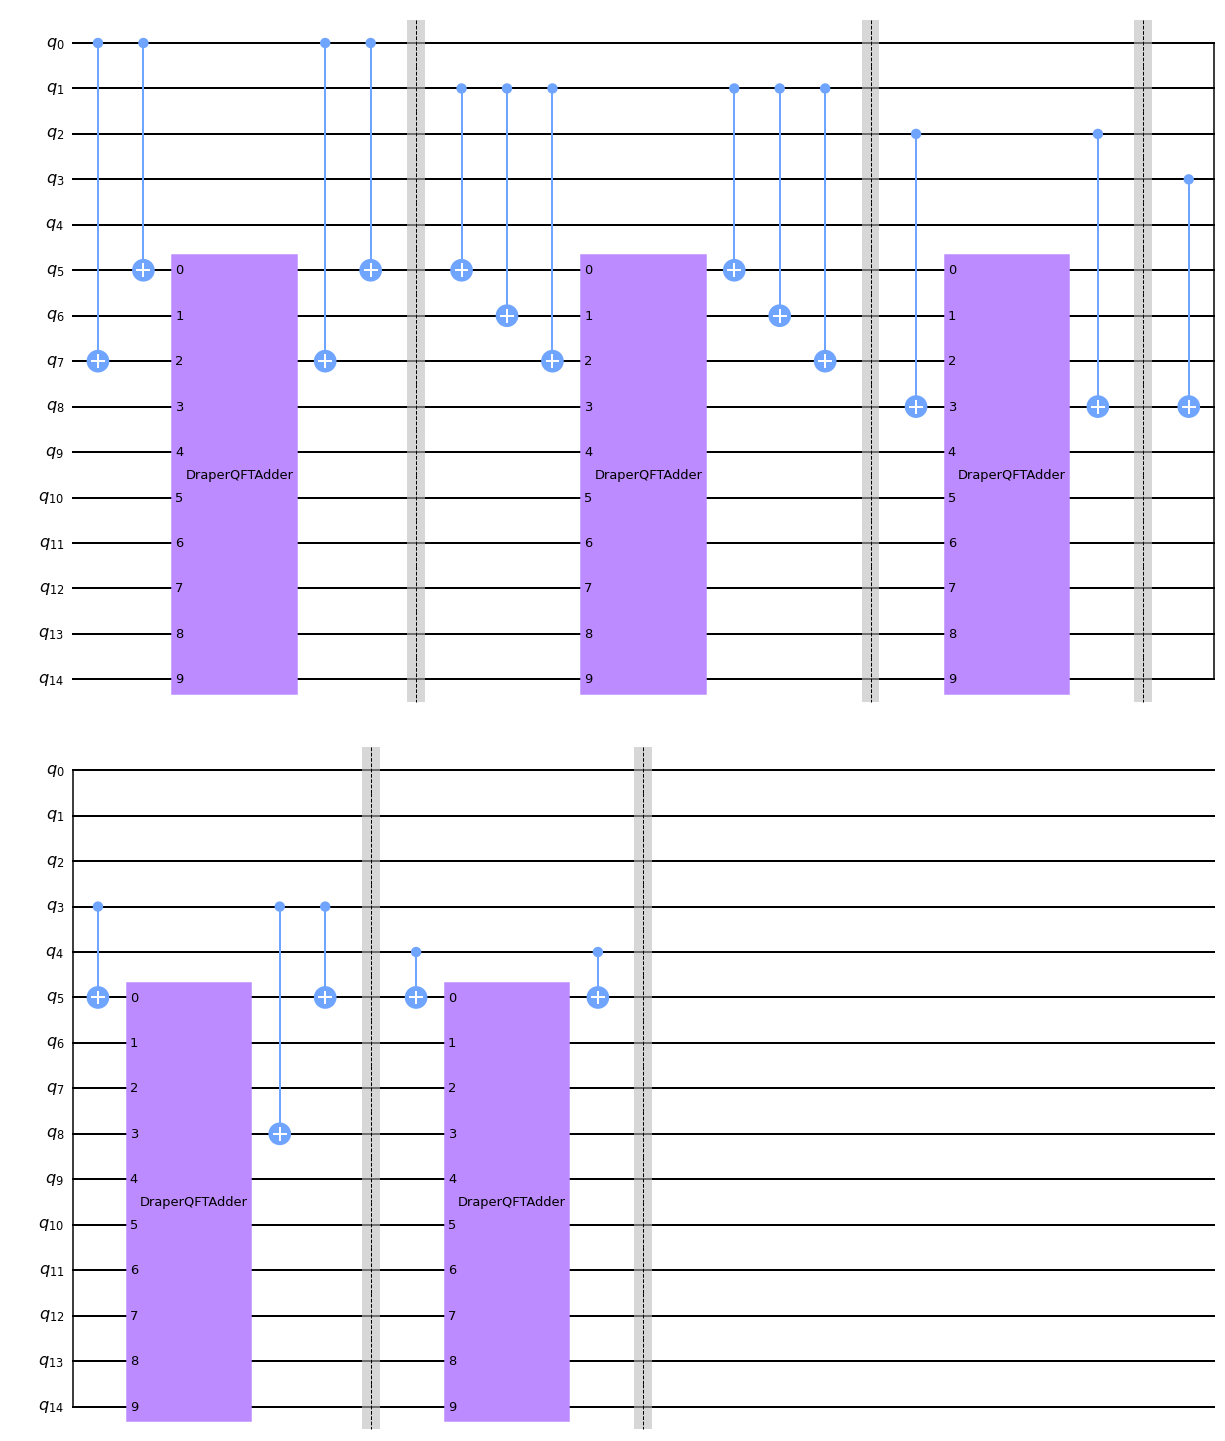

In [503]:
oracle = QuantumCircuit(N + B + B)
oracle.cx(0,7)
oracle.cx(0,5)
oracle.append(DraperQFTAdder(B), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(0,7)
oracle.cx(0,5)
oracle.barrier()
oracle.cx(1,5)
oracle.cx(1,6)
oracle.cx(1,7)
oracle.append(DraperQFTAdder(B), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(1,5)
oracle.cx(1,6)
oracle.cx(1,7)
oracle.barrier()
oracle.cx(2,8)
oracle.append(DraperQFTAdder(B), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(2,8)
oracle.barrier()
oracle.cx(3,8)
oracle.cx(3,5)
oracle.append(DraperQFTAdder(B), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(3,8)
oracle.cx(3,5)
oracle.barrier()
oracle.cx(4,5)
oracle.append(DraperQFTAdder(B), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(4,5)
oracle.barrier()
circuit_drawer(oracle, output='mpl')

Before proceeding, let's test the oracle to ensure that it is actually working as intended. The test circuit creates a uniform superposition of queries, queries the oracle, measures the query and sum qubits and returns the result.

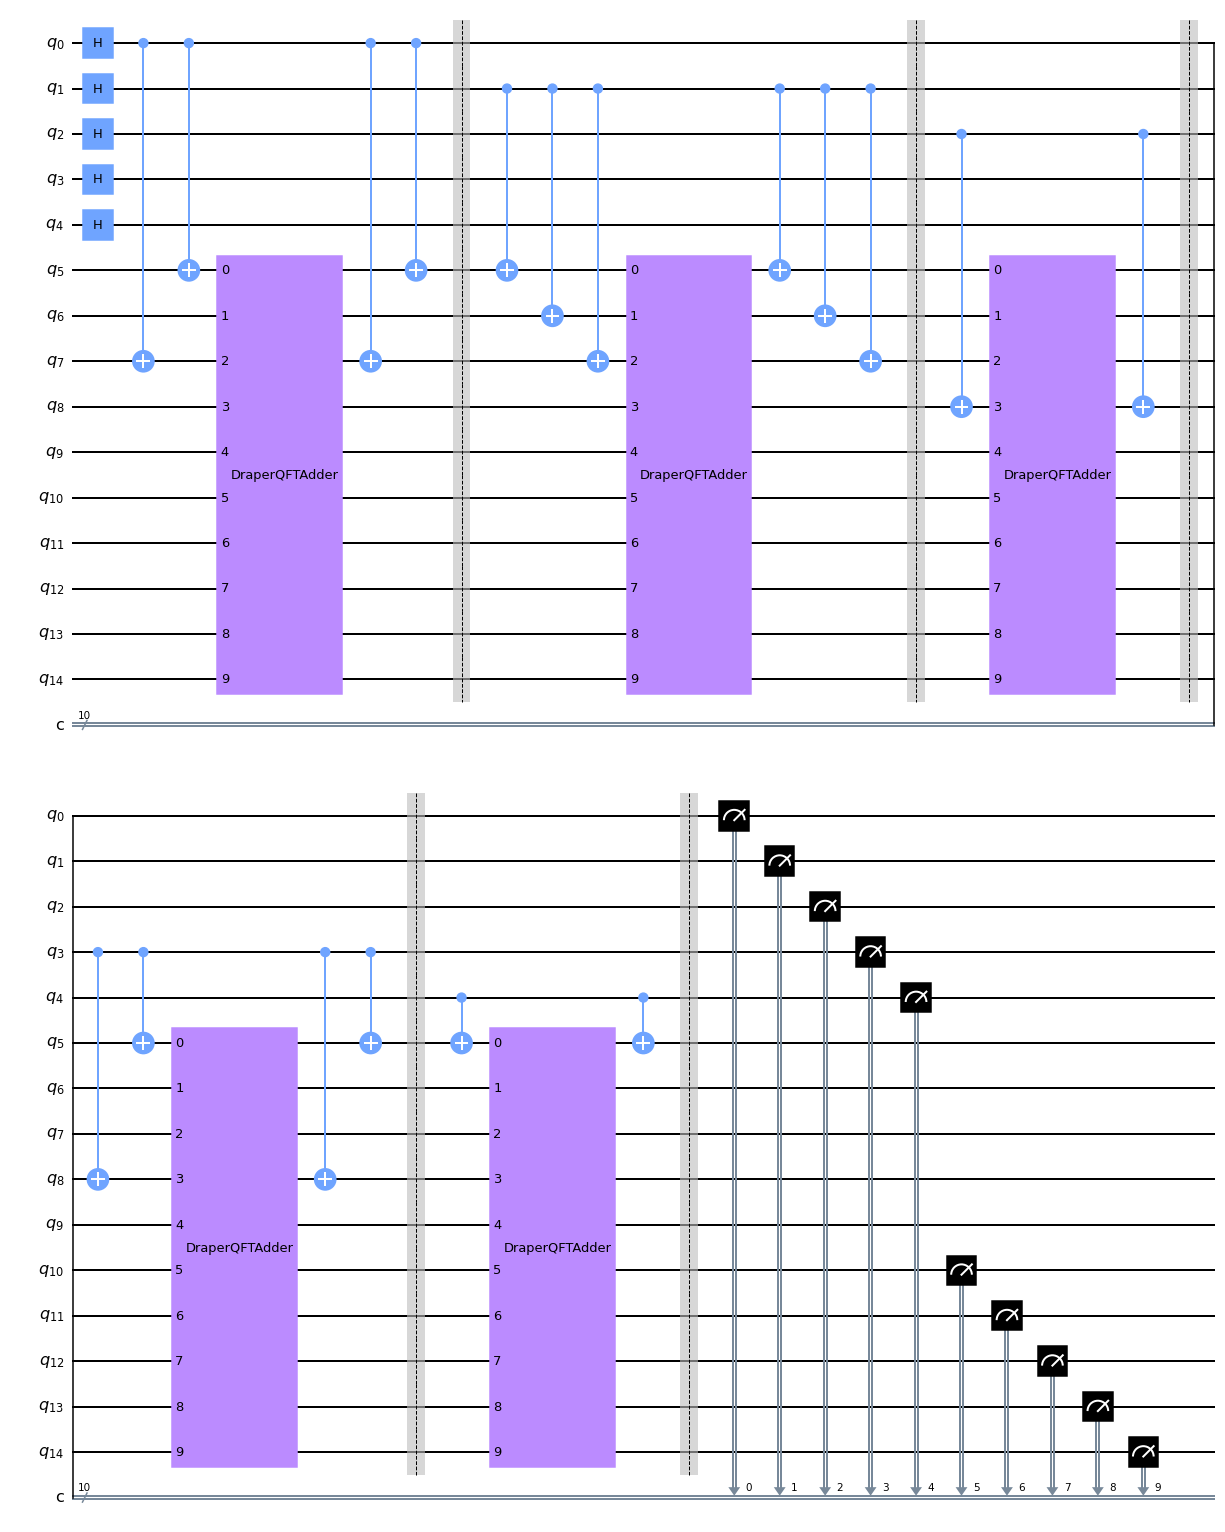

In [504]:
test_circ = QuantumCircuit(N+B+B,N+B)
for i in range(5):
    test_circ.h(i)
test_circ = test_circ.compose(oracle)
test_circ.measure((list(range(N)) + list(range(N+B,N+B+B))), range(N+B))
circuit_drawer(test_circ, output='mpl')

I test the result so far as follows: from each sample from the circuit, I compute which subset was queried and what the result was, and match it with the expected result of the sum. If the computed result and the expected result match for each sample, we are good!

In [505]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
job_sim = backend_sim.run(transpile(test_circ, backend_sim), shots=4096)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(test_circ)

flag = True

for item in counts.keys():
    num = 0
    comp = np.dot(LIST, [int(item[-(i+1)]) for i in range(5)])
    for id, c in enumerate(item[:5]):
        c = int(c)
        num += c * 2**(B - 1 - id)
    if num != comp:
        flag = False
        break
if not flag:
    print('Not working :(')
else:
    print('Working!')

Working!


I plot the outputs. Clearly, no one input dominates the rest. This is of course to be expected since we queried in equal superposition. 

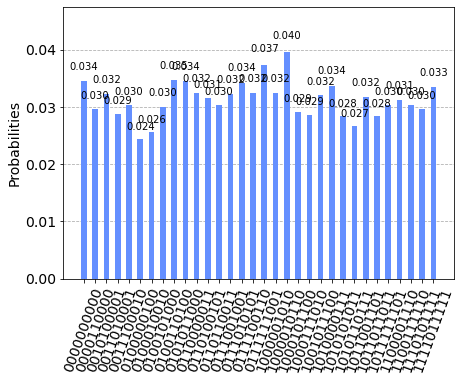

In [506]:
plot_histogram(result_sim.get_counts())

### Increasing the success probability using Grover search

#### Creating the Grover oracle

We have created some oracle, but right now if there are $m$ subsets that add up to $16$ (in this case $m=2$), the algorithm has only an $m/2^N$ chance of getting the correct answer. That is not good enough.

The way I increase this is by using Grover search. Define a function $f$ such that takes (the encoding of) a subset as input, and returns $1$ if the sum of that subset is $16$ and zero otherwise. I will now construct an oracle $\mathcal{O}_f$ that has the following form:

\begin{align*}
    \mathcal{O}_f \ket{x} \otimes \ket{0}^m = (-1)^{f(x)} \ket{x} \otimes \ket{0}^m
\end{align*}

I will take $m = 2B$. To do this, I start with the oracle I defined above and build on top of it. 


I first test if the sum qubits encode the number $16$. In binary, $16$ is $10000$, and so a classical Boolean formula to check this would be $(\neg a_0) \land (\neg a_1) \land (\neg a_2) \land (\neg a_3) \land a_4$. Inspired by this, I check this quantumly by applying an $X$ gate to the qubits representing $a_0$, $a_1$, $a_2$ and $a_3$, and take a multi-controlled $X$-gate onto one of the other ancilla qubits. 

In [507]:
oracle.x(10)
oracle.x(11)
oracle.x(12)
oracle.x(13)
oracle.mcx([10,11,12,13,14], 9)

To now get the required phase shift, I do a controlled phase shift from the ancilla qubit I just used to the one of the sum qubits. By construction, I know that this ancilla qubit is $\ket{1}$ if and only if *all* of the sum qubits are $\ket{1}$, and so this will add a phase if and only if the sum qubits encode $16$.

In [508]:
oracle.cp(math.pi, 9, 14)

Now, I need to uncompute everything in the ancilla qubits to get it into the form I want. This is not hard, since most of the gates are self-inverses. The uncomputation is accomplished in the following.

In [509]:
oracle.mcx([10,11,12,13,14], 9)
oracle.x(10)
oracle.x(11)
oracle.x(12)
oracle.x(13)
oracle.barrier()
oracle.cx(4,5)
oracle.append(DraperQFTAdder(B).inverse(), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(4,5)
oracle.barrier()
oracle.cx(3,8)
oracle.cx(3,5)
oracle.append(DraperQFTAdder(B).inverse(), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(3,8)
oracle.cx(3,5)
oracle.barrier()
oracle.cx(2,8)
oracle.append(DraperQFTAdder(B).inverse(), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(2,8)
oracle.barrier()
oracle.cx(1,5)
oracle.cx(1,6)
oracle.cx(1,7)
oracle.append(DraperQFTAdder(B).inverse(), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(1,5)
oracle.cx(1,6)
oracle.cx(1,7)
oracle.barrier()
oracle.cx(0,7)
oracle.cx(0,5)
oracle.append(DraperQFTAdder(B).inverse(), [5,6,7,8,9,10,11,12,13,14])
oracle.cx(0,7)
oracle.cx(0,5)
oracle.barrier()

The full circuit is as follows. 

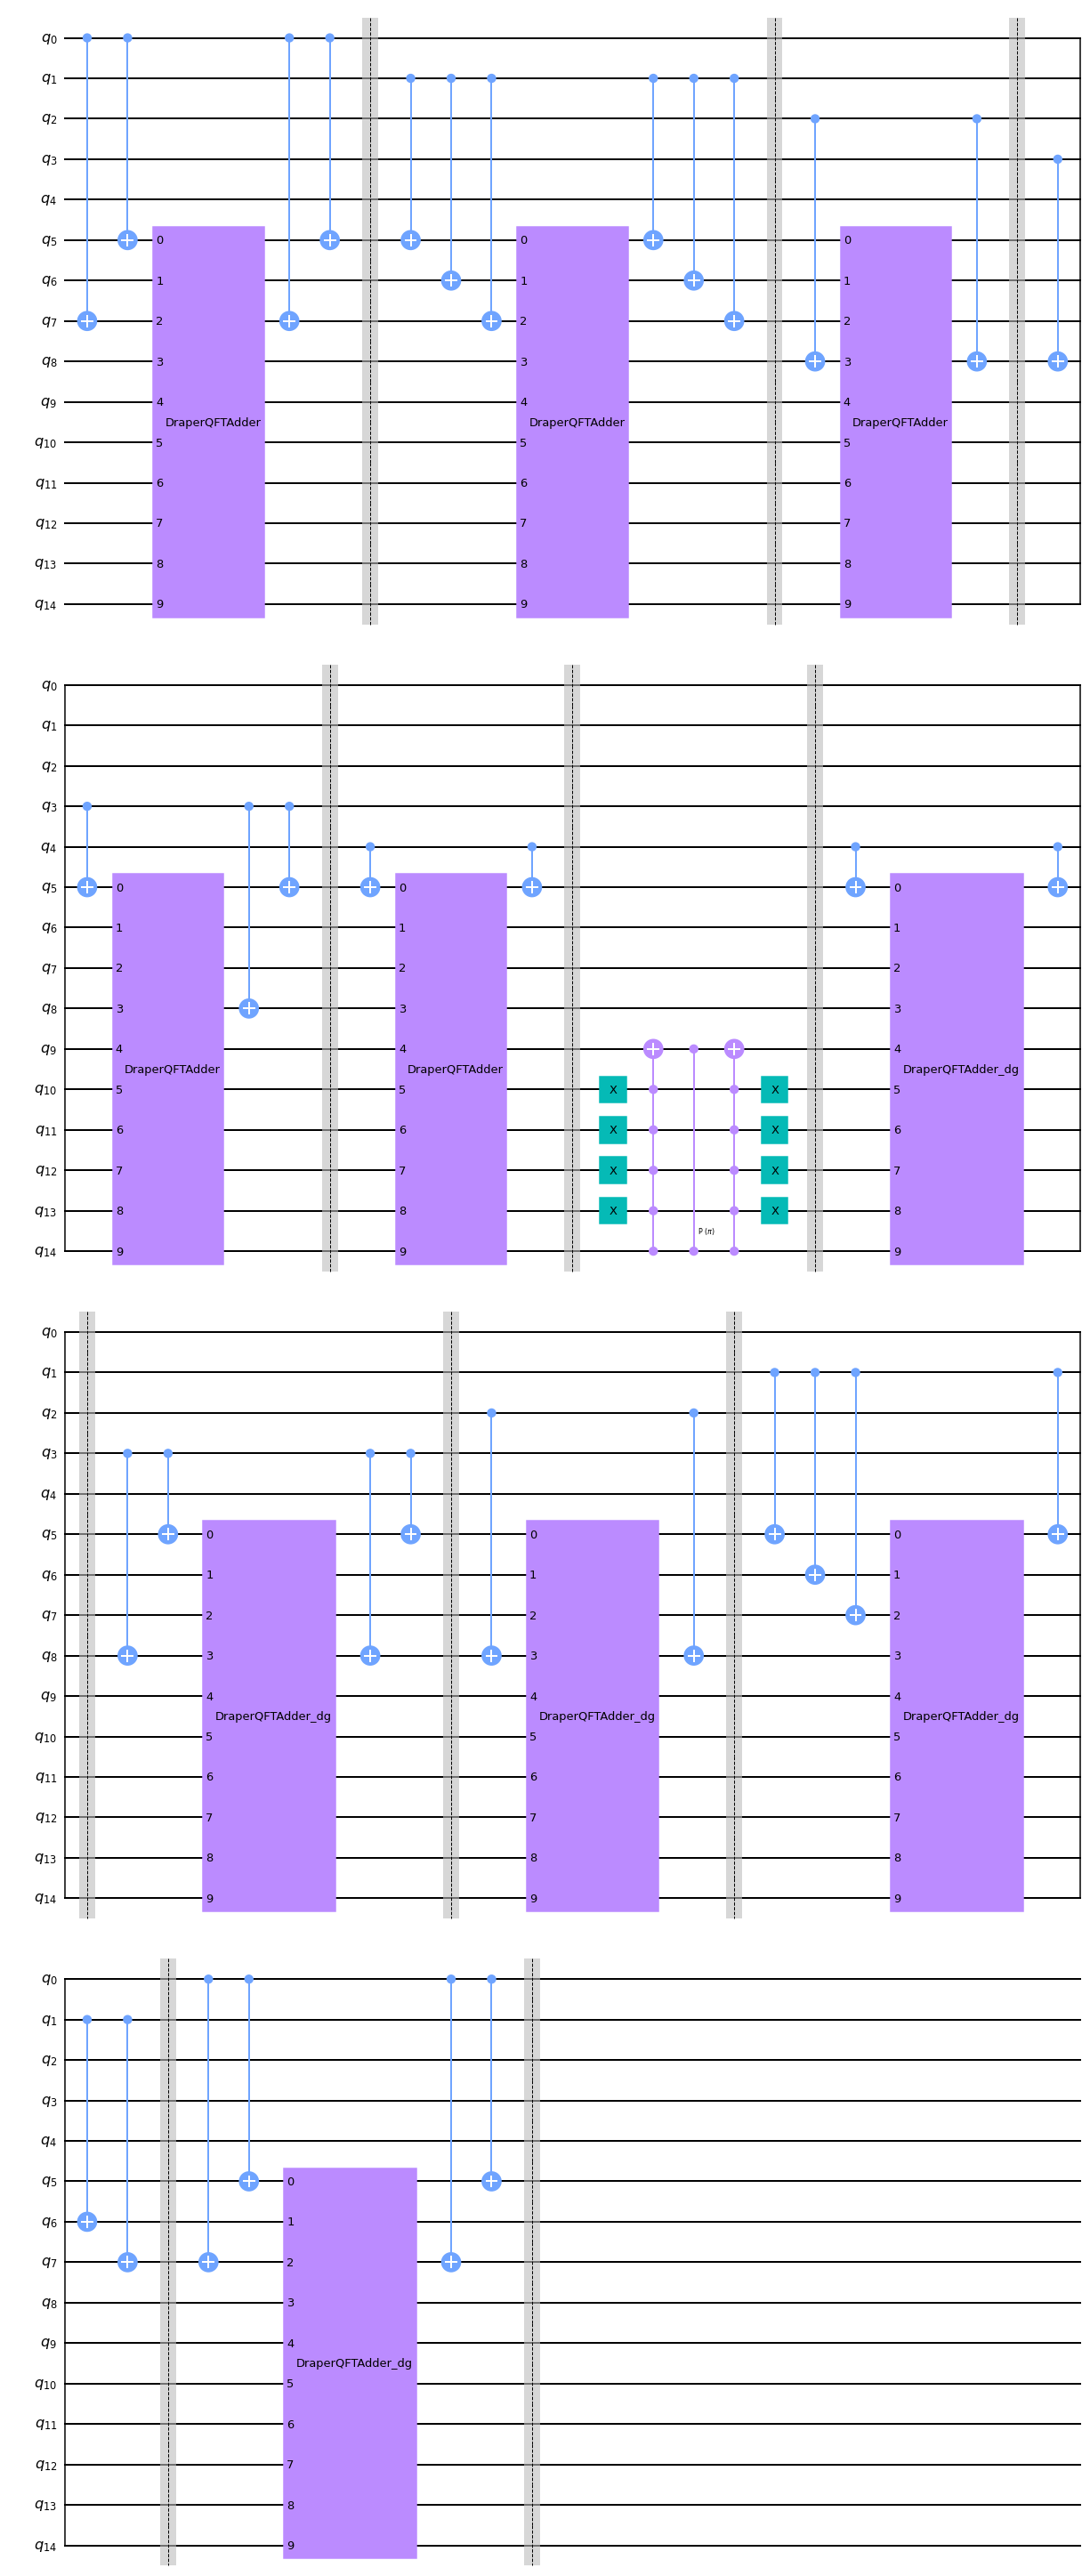

In [510]:
circuit_drawer(oracle, output='mpl')

I will now put the entire oracle into a function. It takes two integer parameters, $n$ and $b$, which play the same roles as $N$ and $B$. I also turned the oracle into a composite gate that I can then stick into other circuits.

In [511]:
def oracle(n: int, b: int) -> QuantumCircuit:
    oracle = QuantumCircuit(n + b + b)
    oracle.cx(0,7)
    oracle.cx(0,5)
    oracle.append(DraperQFTAdder(b), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(0,7)
    oracle.cx(0,5)
    # oracle.barrier()
    oracle.cx(1,5)
    oracle.cx(1,6)
    oracle.cx(1,7)
    oracle.append(DraperQFTAdder(b), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(1,5)
    oracle.cx(1,6)
    oracle.cx(1,7)
    # oracle.barrier()
    oracle.cx(2,8)
    oracle.append(DraperQFTAdder(b), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(2,8)
    # oracle.barrier()
    oracle.cx(3,8)
    oracle.cx(3,5)
    oracle.append(DraperQFTAdder(b), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(3,8)
    oracle.cx(3,5)
    # oracle.barrier()
    oracle.cx(4,5)
    oracle.append(DraperQFTAdder(b), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(4,5)
    # oracle.barrier()
    oracle.x(10)
    oracle.x(11)
    oracle.x(12)
    oracle.x(13)
    oracle.mcx([10,11,12,13,14], 9)
    oracle.cp(math.pi, 9, 14)
    oracle.mcx([10,11,12,13,14], 9)
    oracle.x(10)
    oracle.x(11)
    oracle.x(12)
    oracle.x(13)
    # oracle.barrier()
    oracle.cx(4,5)
    oracle.append(DraperQFTAdder(b).inverse(), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(4,5)
    # oracle.barrier()
    oracle.cx(3,8)
    oracle.cx(3,5)
    oracle.append(DraperQFTAdder(b).inverse(), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(3,8)
    oracle.cx(3,5)
    # oracle.barrier()
    oracle.cx(2,8)
    oracle.append(DraperQFTAdder(b).inverse(), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(2,8)
    # oracle.barrier()
    oracle.cx(1,5)
    oracle.cx(1,6)
    oracle.cx(1,7)
    oracle.append(DraperQFTAdder(b).inverse(), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(1,5)
    oracle.cx(1,6)
    oracle.cx(1,7)
    # oracle.barrier()
    oracle.cx(0,7)
    oracle.cx(0,5)
    oracle.append(DraperQFTAdder(b).inverse(), [5,6,7,8,9,10,11,12,13,14])
    oracle.cx(0,7)
    oracle.cx(0,5)
    # oracle.barrier()
    return oracle

o = transpile(oracle(5,5), backend=Aer.get_backend('statevector_simulator'))
o = o.to_gate(label='Oracle')

Let me test this oracle to see if it is functioning as required. To do this, I use $X$ gates to control what is being queried, and use the `statevector_simulator` to see the output state vector. I first check with the subset $[7,9]$, encoded as $01010$, that I know sums to $16$. 

In [512]:
circ = QuantumCircuit(N+B+B)
circ.x(1)
circ.x(3)
circ.append(o, range(N+B+B))

backend = Aer.get_backend('statevector_simulator')
circ = transpile(circ, backend)
job = backend.run(circ)
result = job.result()
outputstate = result.get_statevector(circ, decimals=3)
d = outputstate.to_dict()
print(d)

{'000000000001010': (-1+0j)}


We got the phase of $-1$, so that works! Now I check with a subset, let's say $[5,7,8]$, encoded as $11100$, that does *not* sum to $16$, and see the result.

In [513]:
circ = QuantumCircuit(N+B+B)
circ.x(0)
circ.x(1)
circ.x(2)
circ.append(o, range(N+B+B))

backend = Aer.get_backend('statevector_simulator')
circ = transpile(circ, backend)
job = backend.run(circ)
result = job.result()
outputstate = result.get_statevector(circ, decimals=3)
d = outputstate.to_dict()
print(d)

{'000000000000111': (1-0j)}


Here there's no phase, so that also works! We can check similarly with other subsets. Clearly if it works for these basis states, it also works under superposition. 

#### The inversion around mean circuit

The other ingredient that goes into the Grover iteration is the inversion around mean circuit, the key ingredient of which is the conditional phase-shift circuit $\mathcal{O}_{\phi}$ that has the following action:

\begin{align*}
    \mathcal{O}_{\phi} \ket{x}=
            \begin{cases}
            \ket{x} & \text{if } x = 0,\\
            - \ket{x} & \text{if } x \neq 0.
            \end{cases}
\end{align*}
This is a standard circuit that can be implemented as follows using $X$ gates, $H$ gates and a multicontrolled $X$ gate. I also turned the oracle into a composite gate that I can then stick into other circuits.

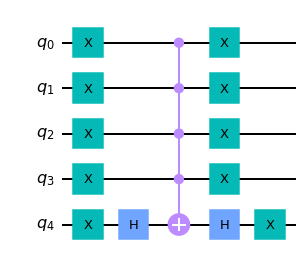

In [514]:
def conditional_ps(n: int) -> QuantumCircuit:
    circ = QuantumCircuit(n)
    for i in range(n):
        circ.x(i)
    # circ.barrier()
    circ.h(n-1)
    circ.mcx([i for i in range(n-1)], n-1)
    circ.h(n-1)
    # circ.barrier()
    for i in range(n):
        circ.x(i)
    return circ
circ = conditional_ps(5)
cp = circ.to_instruction(label='cond-p-shift')
circuit_drawer(circ, output='mpl')

Using this, the inversion around mean circuit can be defined as follows. 

In [515]:
def inv_around_mean(n: int) -> QuantumCircuit:
    circ = QuantumCircuit(n)
    cp = conditional_ps(n).to_gate(label='cond-p-shift')
    for i in range(n):
        circ.h(i)
    circ.append(cp, range(n))
    for i in range(n):
        circ.h(i)
    return circ

circ = inv_around_mean(5)
im = circ.to_gate(label='inv-mean')


With all the pieces in place, we simply run the Grover iteration. Since there are $2$ marked items and $32$ total possibilities, approximately $\sqrt{32/2} = 4$ iterations will suffice. In my testing, I found that $3$ iterations gave the best answer.

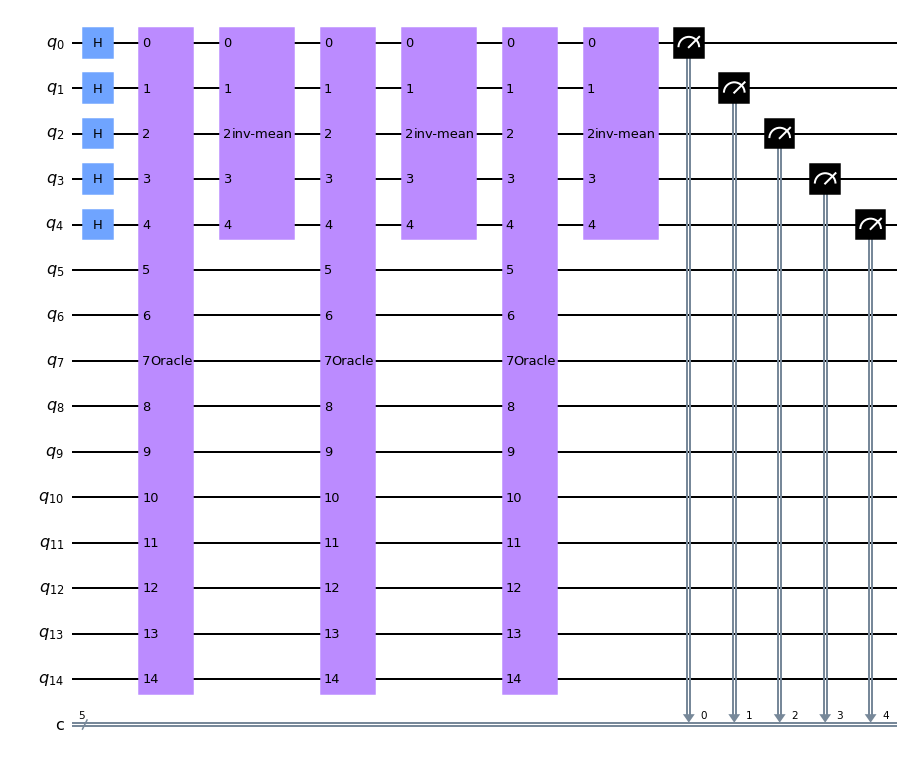

In [516]:
main_circuit = QuantumCircuit(15,5)
for i in range(5):
    main_circuit.h(i)
for _ in range(3):
    main_circuit.append(o, range(15))
    main_circuit.append(im, range(5))
main_circuit.measure(range(5), range(5))
circuit_drawer(main_circuit, output='mpl')

We now test this circuit by running it and sampling the first $N$ qubits.

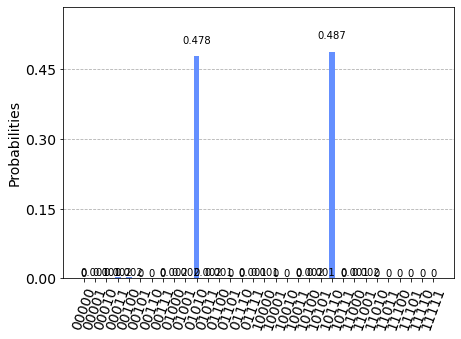

In [517]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(main_circuit, backend_sim), shots=4096)
result_sim = job_sim.result()
counts = result_sim.get_counts(main_circuit)
plot_histogram(result_sim.get_counts())

With some run-to-run variance, the success probability is now around $96\%$!

In [518]:
measured_str = max(counts, key=counts.get)
measured_str

'10110'

Note the way indexing in Qiskit works. In our encoding, the subset indicated is denoted by $01101$ and is the subset $[7,8,1]$. The subset $[7,9]$ is the other highly probable result.

In [519]:
print((counts['10110'] + counts['01010'])/4096)

0.965576171875


### Possible improvements

1. *A priori* we don't know how many solutions there are to the search problem, and therefore we don't know how many times we need to run the Grover iterations. However, this is not hard to fix because the quantum counting algorithm does exactly this and can be run before running the above circuit to estimate the number of solutions.
2. I have used ten ancillary qubits to create the oracle, which, even though less than the 35 I needed in the first attempt, still seems a little excessive. An interesting problem is to try and do it using less qubits, though that might have the side effect of increasing the depth of the circuit.
3. The depth of each Grover iteration is also very high, partly because of how I constructed the oracle. High depth circuits are difficult to implement, so it would be nice to reduce the depth of the circuit (though algorithms such as these are not expected to run on near-term hardware anyway)
4. I have currently hard-coded the circuits based on the specific example that we had to calculate. The way I have made the circuits, however, this can be easily fixed.